In [1]:
import logging
import time

import pandas as pd
import plotly.express as px
import pyro
import pyro.distributions as dist
import pyro.optim as optim
import torch
from pyro.infer import SVI, Predictive, Trace_ELBO
from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean

import collab2.foraging.toolkit as ftk

In [2]:
# load data
fish_data = pd.read_csv("4wpf_test.csv")
gridMin = 0
gridMax = 300
grid_size = 50
fps = 121

# scaling and subsampling
fishDF_scaled = ftk.rescale_to_grid(
    fish_data, size=grid_size, gridMin=gridMin, gridMax=gridMax
)
fishDF_scaled_subsampled = ftk.subsample_frames_constant_frame_rate(
    fishDF_scaled, frame_spacing=121, fps=fps
)

# create a test foragers object with 20 frames
num_frames = 10
foragers_object = ftk.dataObject(
    fishDF_scaled_subsampled.loc[fishDF_scaled_subsampled["time"] < num_frames],
    grid_size=grid_size,
)

original_frames: 18739
original_shape: (74956, 5)
resulting_frames: 155
resulting_shape: (620, 5)
new frame-rate =  1.00


/home/rafal/s78projects/collab-creatures/collab2/foraging/toolkit/utils.py:42: UserWarning: 
                NaN values in data. The default behavior of predictor/score generating functions is
                to ignore foragers with missing positional data. To modify, see documentation of
                `derive_predictors_and_scores` and `generate_local_windows`
                
  warnings.warn(


In [3]:
# derive predictors

local_windows_kwargs = {
    "window_size": 15,
    "sampling_fraction": 1,
    "skip_incomplete_frames": True,
}

predictor_kwargs = {
    "vicsek": {
        "interaction_length": grid_size / 3,
        "interaction_constraint": None,
        "interaction_constraint_params": None,
        "dt": 1,
        "sigma_v": 3,
        "sigma_t": 0.3,
    },
    "vicsek_large_sigma": {
        "interaction_length": grid_size / 3,
        "interaction_constraint": None,
        "interaction_constraint_params": None,
        "dt": 1,
        "sigma_v": 10,
        "sigma_t": 1,
    },
    "pairwiseCopying": {
        "interaction_length": grid_size / 3,
        "interaction_constraint": None,
        "interaction_constraint_params": None,
        "dt": 1,
        "sigma_v": 3,
        "sigma_t": 0.3,
    },
    "proximity": {
        "interaction_length": grid_size / 3,
        "interaction_constraint": None,
        "interaction_constraint_params": None,
        "repulsion_radius": 1.5,
        "optimal_distance": 4,
        "proximity_decay": 1,
    },
}

score_kwargs = {
    "nextStep_linear": {"nonlinearity_exponent": 1},
    "nextStep_sublinear": {"nonlinearity_exponent": 0.5},
}

derivedDF = ftk.derive_predictors_and_scores(
    foragers_object,
    local_windows_kwargs,
    predictor_kwargs=predictor_kwargs,
    score_kwargs=score_kwargs,
    dropna=True,
    add_scaled_values=True,
)

2024-09-04 19:28:25,303 - vicsek completed in 0.16 seconds.
2024-09-04 19:28:25,461 - vicsek_large_sigma completed in 0.16 seconds.
2024-09-04 19:28:25,726 - pairwiseCopying completed in 0.26 seconds.
2024-09-04 19:28:25,867 - proximity completed in 0.14 seconds.
2024-09-04 19:28:25,893 - nextStep_linear completed in 0.03 seconds.
2024-09-04 19:28:25,917 - nextStep_sublinear completed in 0.02 seconds.
/home/rafal/s78projects/collab-creatures/collab2/foraging/toolkit/derive.py:56: UserWarning: 
                      Dropped 8277/25075 frames from `derivedDF` due to NaN values.
                      Missing values can arise when computations depend on next/previous step positions
                      that are unavailable. See documentation of the corresponding predictor/score generating
                      functions for more information.
                      
  warnings.warn(


In [4]:
display(derivedDF)

,x,y,distance_to_f,time,forager,vicsek,vicsek_large_sigma,pairwiseCopying,proximity,distance_to_next_step,nextStep_linear,nextStep_sublinear,vicsek_scaled,vicsek_large_sigma_scaled,pairwiseCopying_scaled,proximity_scaled,nextStep_linear_scaled,nextStep_sublinear_scaled
697,19,19,15.000000,1,0,2.333703e-25,0.006069,2.015709e-11,0.000072,14.000000,0.125000,0.064586,2.333601e-25,0.003619,2.015709e-11,0.428935,0.125000,0.064586
698,20,14,14.866069,1,0,9.256047e-21,0.015739,8.391062e-14,0.000009,13.928388,0.129476,0.066981,9.256047e-21,0.013313,8.391062e-14,0.428899,0.129476,0.066981
699,20,15,14.560220,1,0,2.267917e-21,0.013868,2.174845e-13,0.000018,13.601471,0.149908,0.077996,2.267917e-21,0.011437,2.174845e-13,0.428904,0.149908,0.077996
700,20,16,14.317821,1,0,4.450581e-22,0.011977,1.117982e-12,0.000034,13.341664,0.166146,0.086844,4.450581e-22,0.009542,1.117982e-12,0.428913,0.166146,0.086844
701,20,17,14.142136,1,0,7.065420e-23,0.010149,5.522924e-12,0.000061,13.152946,0.177941,0.093325,7.065419e-23,0.007709,5.522924e-12,0.428929,0.177941,0.093325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24361,48,26,14.142136,8,3,6.896891e-06,0.343146,7.092926e-05,0.000055,21.023796,0.045359,0.022942,6.896891e-06,0.341527,7.092926e-05,0.428925,0.045359,0.022942
24362,48,27,14.317821,8,3,3.240315e-06,0.320592,5.465289e-05,0.000049,21.095023,0.042124,0.021289,3.240315e-06,0.318918,5.465289e-05,0.428922,0.042124,0.021289
24363,48,28,14.560220,8,3,1.320367e-06,0.295708,3.876775e-05,0.000041,21.213203,0.036758,0.018551,1.320367e-06,0.293972,3.876775e-05,0.428917,0.036758,0.018551
24364,48,29,14.866069,8,3,4.706635e-07,0.269491,2.563767e-05,0.000032,21.377558,0.029295,0.014756,4.706635e-07,0.267690,2.563767e-05,0.428912,0.029295,0.014756


# Try inference pipeline

In [5]:
# convert predictors and scores to tensors
vicsek = torch.tensor(derivedDF["vicsek"].values)
pCopying = torch.tensor(derivedDF["pairwiseCopying"].values)
score = torch.tensor(derivedDF["nextStep_linear"].values)

/home/rafal/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


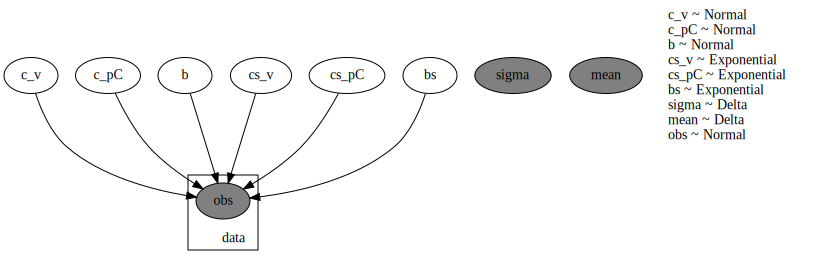

In [6]:
# define the probabilistic model using pyro (https://pyro.ai/)
# c_v, c_pC, b are the coefficients
# for vicsek, pairwiseCopying and the intercept

# cs_v, cs_pC, bs are analogous coefficients,
# but they contribute to the variance,
# which is not assumed to remain fixed


def model_sigmavar(vicsek, pCopying, score):
    c_v = pyro.sample("c_v", dist.Normal(0, 0.2))
    c_pC = pyro.sample("c_pC", dist.Normal(0, 0.2))
    b = pyro.sample("b", dist.Normal(0.5, 0.3))

    cs_v = pyro.sample("cs_v", dist.Exponential(7))
    cs_pC = pyro.sample("cs_pC", dist.Exponential(7))
    bs = pyro.sample("bs", dist.Exponential(7))

    sigma = pyro.deterministic("sigma", bs + cs_v * vicsek + cs_pC * pCopying)
    mean = pyro.deterministic("mean", b + c_v * vicsek + c_pC * pCopying)

    with pyro.plate("data", len(score)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=score)


pyro.render_model(
    model_sigmavar,
    model_args=(vicsek, pCopying, score),
    render_distributions=True,
)

In [7]:
# helper functions for inference, showing results

num_svi_iters = 500
num_samples = 1000


def summary(samples, sites):
    site_stats = {}
    for site_name, values in samples.items():
        if site_name in sites:
            marginal_site = pd.DataFrame(values)
            describe = marginal_site.describe(
                percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]
            ).transpose()
            site_stats[site_name] = describe[
                ["mean", "std", "5%", "25%", "50%", "75%", "95%"]
            ]
    return site_stats


def get_samples(
    vicsek,
    pCopying,
    score,
    model=model_sigmavar,
    num_svi_iters=num_svi_iters,
    num_samples=num_samples,
):
    guide = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)
    svi = SVI(model_sigmavar, guide, optim.Adam({"lr": 0.01}), loss=Trace_ELBO())

    iterations = []
    losses = []

    logging.info(f"Starting SVI inference with {num_svi_iters} iterations.")
    start_time = time.time()
    pyro.clear_param_store()
    for i in range(num_svi_iters):
        elbo = svi.step(vicsek, pCopying, score)
        iterations.append(i)
        losses.append(elbo)
        if i % 200 == 0:
            logging.info("Elbo loss: {}".format(elbo))
    end_time = time.time()
    elapsed_time = end_time - start_time
    logging.info("SVI inference completed in %.2f seconds.", elapsed_time)

    fig = px.line(x=iterations, y=losses, title="ELBO loss", template="presentation")
    labels = {"iterations": "iteration", "losses": "loss"}
    fig.update_xaxes(showgrid=False, title_text=labels["iterations"])
    fig.update_yaxes(showgrid=False, title_text=labels["losses"])
    fig.update_layout(width=700)
    fig.show()

    predictive = Predictive(
        model, guide=guide, num_samples=num_samples, return_sites=["c_v", "c_pC"]
    )
    test_svi = {
        k: v.flatten().reshape(num_samples, -1).detach().cpu().numpy()
        for k, v in predictive(vicsek, pCopying, score).items()
        if k != "obs"
    }

    print("SVI-based coefficient marginals:")
    for site, values in summary(test_svi, ["c_v", "c_pC"]).items():
        print("Site: {}".format(site))
        print(values, "\n")

    return {"svi_samples": test_svi, "svi_guide": guide, "svi_predictive": predictive}


def calculate_R_squared(guide):
    predictive = pyro.infer.Predictive(model_sigmavar, guide=guide, num_samples=1000)
    predictions = predictive(vicsek, pCopying, score)

    simulated_outcome = (
        predictions["b"] + predictions["c_v"] * vicsek + predictions["c_pC"] * pCopying
    )

    mean_sim_outcome = simulated_outcome.mean(0).detach().cpu().numpy()

    observed_mean = torch.mean(score)

    tss = torch.sum((score - observed_mean) ** 2)
    rss = torch.sum((score - mean_sim_outcome) ** 2)

    r_squared = 1 - (rss / tss)

    return r_squared.float().item()

In [8]:
samples_test = get_samples(vicsek, pCopying, score)

2024-09-04 19:28:28,998 - Starting SVI inference with 500 iterations.
2024-09-04 19:28:29,636 - Elbo loss: 4988.297318851346
2024-09-04 19:28:31,618 - Elbo loss: -2059.3212547791245
2024-09-04 19:28:33,667 - Elbo loss: -2450.959754866407
2024-09-04 19:28:34,187 - SVI inference completed in 5.19 seconds.


SVI-based coefficient marginals:
Site: c_v
       mean       std        5%       25%       50%       75%       95%
0  0.121589  0.045907  0.047035  0.091075  0.121011  0.153419  0.197199 

Site: c_pC
      mean       std        5%       25%       50%       75%       95%
0  0.53206  0.041007  0.465126  0.503058  0.532288  0.560166  0.604196 



In [9]:
# plot the inferred posterior distributions of the coefficients
# Note that the model infers that the random foragers have
# near-zero coefficients for food trace and proximity score.
# The non-zero coefficient for visibility is consistent with the
# fact that the random foragers are mostly likely to move to nearby
# locations (higher visibility score) compared to farther locations.
ftk.plot_coefs(
    samples_test, "Test fish data", nbins=120, ann_start_y=160, ann_break_y=50
)

/home/rafal/miniconda3/envs/collab/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

